In [4]:
import numpy as np
import pandas as pd
from importlib import reload
import heston
import matplotlib.pyplot as plt
import levenberg_marquardt
reload(levenberg_marquardt)
reload(heston)
from heston import fHes, JacHes, MarketParameters, ModelParameters
from levenberg_marquardt import LevenbergMarquardt
from typing import Tuple

In [ ]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
df = df.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in df.symbol]
df = df[ind].reset_index(drop=True)

In [ ]:
df.head()

In [163]:
sample = select_data(df)

In [165]:
sample.head()

,type,expiration,strike_price,symbol,local_timestamp,mark_price,mark_iv,underlying_price,tau,payoff,inverse_payoff,mark_price_usd
37,call,1669968000000000,1300,ETH-2DEC22-1300-C,1669939198921651,0.0020,67.10,1276.19,0.000913,0.0,0.0,2.552380
38,call,1669968000000000,1325,ETH-2DEC22-1325-C,1669939199011544,0.0007,82.58,1276.18,0.000913,0.0,0.0,0.893326
39,call,1669968000000000,1350,ETH-2DEC22-1350-C,1669939196493828,0.0007,113.09,1276.21,0.000913,0.0,0.0,0.893347
40,call,1669968000000000,1400,ETH-2DEC22-1400-C,1669939196493034,0.0000,115.00,1276.21,0.000913,0.0,0.0,0.000000
41,call,1669968000000000,1500,ETH-2DEC22-1500-C,1669939196485910,0.0000,124.50,1276.21,0.000913,0.0,0.0,0.000000


In [171]:
sing_exp = sample[sample["expiration"] == sample.sample(1).iloc[0].expiration]
# can calibrate on all expirations
# sing_exp = sample.copy()
karr = sing_exp.strike_price.to_numpy(dtype=np.float64)
carr = sing_exp.mark_price_usd.to_numpy(dtype=np.float64)
tarr = sing_exp.tau.to_numpy(dtype=np.float64)
r_val = np.float64(0.0)
S_val = np.float64(sing_exp.underlying_price.mean())
market = MarketParameters(K=karr, T=tarr, S=S_val, r=r_val, C = carr)
typ = np.where(sing_exp["type"] =="call", True, False)

In [172]:
def proj_heston( heston_params : np.ndarray )->np.ndarray:
    """
        This funciton project heston parameters into valid range
        Attributes:
            heston_params(np.ndarray): model parameters
        
        Returns:
            heston_params(np.ndarray): clipped parameters
    """
    eps = 1e-4
    for i in range(len(heston_params) // 5):
        a, b, c, rho, v0 = heston_params[i * 5 : i * 5 + 5]
        a = np.clip(a, eps, 100.0)
        b = np.clip(b, eps, 100.0)
        c = np.clip(c, eps, 100.0)
        rho = np.clip(rho, -1 + eps, 1 - eps)
        v0 = np.clip(v0, eps, 100.0)
        heston_params[i * 5 : i * 5 + 5] = a, b, c, rho, v0
    
    return heston_params

def get_residuals( heston_params:np.ndarray ) -> Tuple[ np.ndarray, np.ndarray ]:
    '''
        This function calculates residuals and Jacobian matrix
        Args:
            heston_params(np.ndarray): model params
        Returns:
            res(np.ndarray) : vector or residuals
            J(np.ndarray)   : Jacobian
    '''
    # needed format to go
    model_parameters = ModelParameters(
            heston_params[0],
            heston_params[1],
            heston_params[2],
            heston_params[3],
            heston_params[4])
    # тут ок в целом, надо подогнать дальше и смотреть
    #  чтоб ваще те параметры подставлялись в якобиан
    C = fHes(
    model_parameters=model_parameters,
    market_parameters=market,
    )

    J = JacHes(
    model_parameters=model_parameters, 
    market_parameters=market)

    K = karr
    F = np.ones(len(K))*market.S
    weights = np.ones_like(K)
    weights = weights / np.sum(weights)
    P = C + np.exp(-market.r * market.T) * ( K - F )
    X_ = C
    X_[~typ] = P[~typ]
    res = X_ - market.C
    return res * weights,  J @ np.diag(weights)


a = np.float64(3.0)  # kappa                     |  mean reversion rate
b = np.float64(0.1)  # v_infinity               |  long term variance
c = np.float64(0.25)  # sigma                    |  variance of volatility
rho = np.float64(0.01)  # rho                    |  correlation between spot and volatility
v0 = np.float64(0.08) # init variance            | initial variance   

start_params = np.array([a, b, c, rho, v0])
res = Levenberg_Marquardt(100, get_residuals, proj_heston, start_params)
calibrated_params = np.array(res["x"], dtype = np.float64)
names = ["kappa", "nu_bar", "sigma", "rho", "nu0"]
print("optimized parameters:", *zip(names, (calibrated_params).round(5)), sep='\n' )



optimized parameters:
('kappa', 0.04124)
('nu_bar', 78.10037)
('sigma', 3.65027)
('rho', -0.37996)
('nu0', 0.0001)


Text(0.5, 0, 'LM iteration')

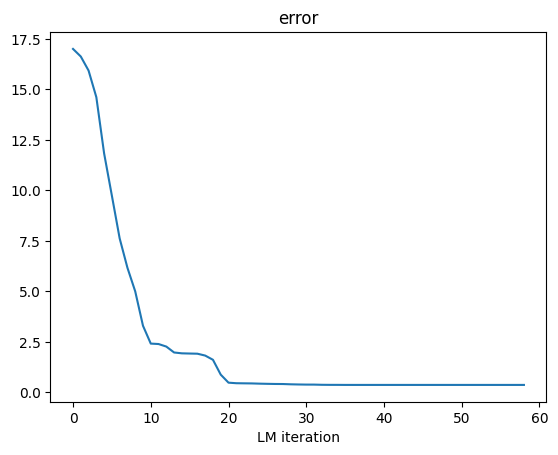

In [173]:
plt.plot(list(range(len(res["objective"]))), res["objective"])
plt.title("error")
plt.xlabel("LM iteration")

In [174]:
calibrated_params_model = ModelParameters(
            calibrated_params[0],
            calibrated_params[1],
            calibrated_params[2],
            calibrated_params[3],
            calibrated_params[4])

calibr_C = fHes(
    model_parameters=calibrated_params_model,
    market_parameters=market,
    )

sing_exp["mark_price_calibrated"] = calibr_C
sing_exp.loc[sing_exp["type"] == "put", "mark_price_calibrated"] = (sing_exp["mark_price_calibrated"] + 
    np.exp(-market.r * sing_exp["tau"]) * (sing_exp["strike_price"] - sing_exp["underlying_price"]))
sing_exp

/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_21835/2967910722.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sing_exp["mark_price_calibrated"] = calibr_C


,type,expiration,strike_price,symbol,local_timestamp,mark_price,mark_iv,underlying_price,tau,payoff,inverse_payoff,mark_price_usd,mark_price_calibrated
275,call,1688112000000000,1300,ETH-30JUN23-1300-C,1669939196486772,0.2266,78.46,1274.58,0.576256,0.0,0.0,288.819828,286.087887
276,call,1688112000000000,1400,ETH-30JUN23-1400-C,1669939196495767,0.1956,77.19,1274.58,0.576256,0.0,0.0,249.307848,246.191876
277,call,1688112000000000,1500,ETH-30JUN23-1500-C,1669939196487792,0.1674,75.74,1274.58,0.576256,0.0,0.0,213.364692,212.072074
278,call,1688112000000000,1600,ETH-30JUN23-1600-C,1669939196498611,0.1453,75.34,1274.58,0.576256,0.0,0.0,185.196474,183.229512
279,call,1688112000000000,1700,ETH-30JUN23-1700-C,1669939191455109,0.1245,74.45,1274.37,0.576256,0.0,0.0,158.659065,159.033328
280,call,1688112000000000,1800,ETH-30JUN23-1800-C,1669939196487464,0.1091,74.49,1274.58,0.576256,0.0,0.0,139.056678,138.806083
281,call,1688112000000000,1900,ETH-30JUN23-1900-C,1669939196485910,0.0955,74.49,1274.58,0.576256,0.0,0.0,121.722390,121.895954
282,call,1688112000000000,2000,ETH-30JUN23-2000-C,1669939196503544,0.0840,74.64,1274.58,0.576256,0.0,0.0,107.064720,107.719683
283,call,1688112000000000,2100,ETH-30JUN23-2100-C,1669939196499370,0.0741,74.75,1274.58,0.576256,0.0,0.0,94.446378,95.780470
284,call,1688112000000000,2200,ETH-30JUN23-2200-C,1669939199512624,0.0653,74.85,1274.47,0.576256,0.0,0.0,83.222891,85.667858
